In [16]:
#For th EDA phase for visualization following libraries were used: pandas, numpy,matplotlib and seaborn. 
import boto3
import sagemaker

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

In [6]:
#To establish connection to database and query Athena directly from notebook pyathena db client was used
from pyathena import connect
database_name = "amazon_reviews_capstone"
table_name = "amazon_reviews_parquet"

In [7]:
conn = connect(region_name=region, s3_staging_dir= "s3://{0}/athena/staging".format(bucket))

In [53]:
def plot_highest_rated_categories(axs, space):
    def _show_on_plot(ax):
        for p in ax.patches:
            _x = p.get_x() + p.get_width() + float(space)
            _y = p.get_y() + p.get_height()
            value = round(float(p.get_width()), 2)
            ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_plot(ax)
    else:
        _show_on_plot(axs)

In [54]:
# In order to get which product categories are highest rated by average ratin we will query AWS Athena
statement = """
SELECT product_category, AVG(star_rating) AS avg_star_rating
FROM {}.{} 
GROUP BY product_category 
ORDER BY avg_star_rating DESC
""".format(
    database_name, table_name
)

print(statement)


SELECT product_category, AVG(star_rating) AS avg_star_rating
FROM amazon_reviews_capstone.amazon_reviews_parquet 
GROUP BY product_category 
ORDER BY avg_star_rating DESC



In [57]:
# Reviewing just the first 5 rows of the dataframe
df = pd.read_sql(statement, conn)

df.head(5)

,product_category,avg_star_rating
0,Gift Card,4.731363
1,Digital_Music_Purchase,4.638183
2,Music,4.441017
3,Books,4.340448
4,Video DVD,4.318037


In [56]:
# Review how many categories we have in the dataset
num_categories = df.shape[0]
print(num_categories)

# Store average star ratings
avg_sr = df

43


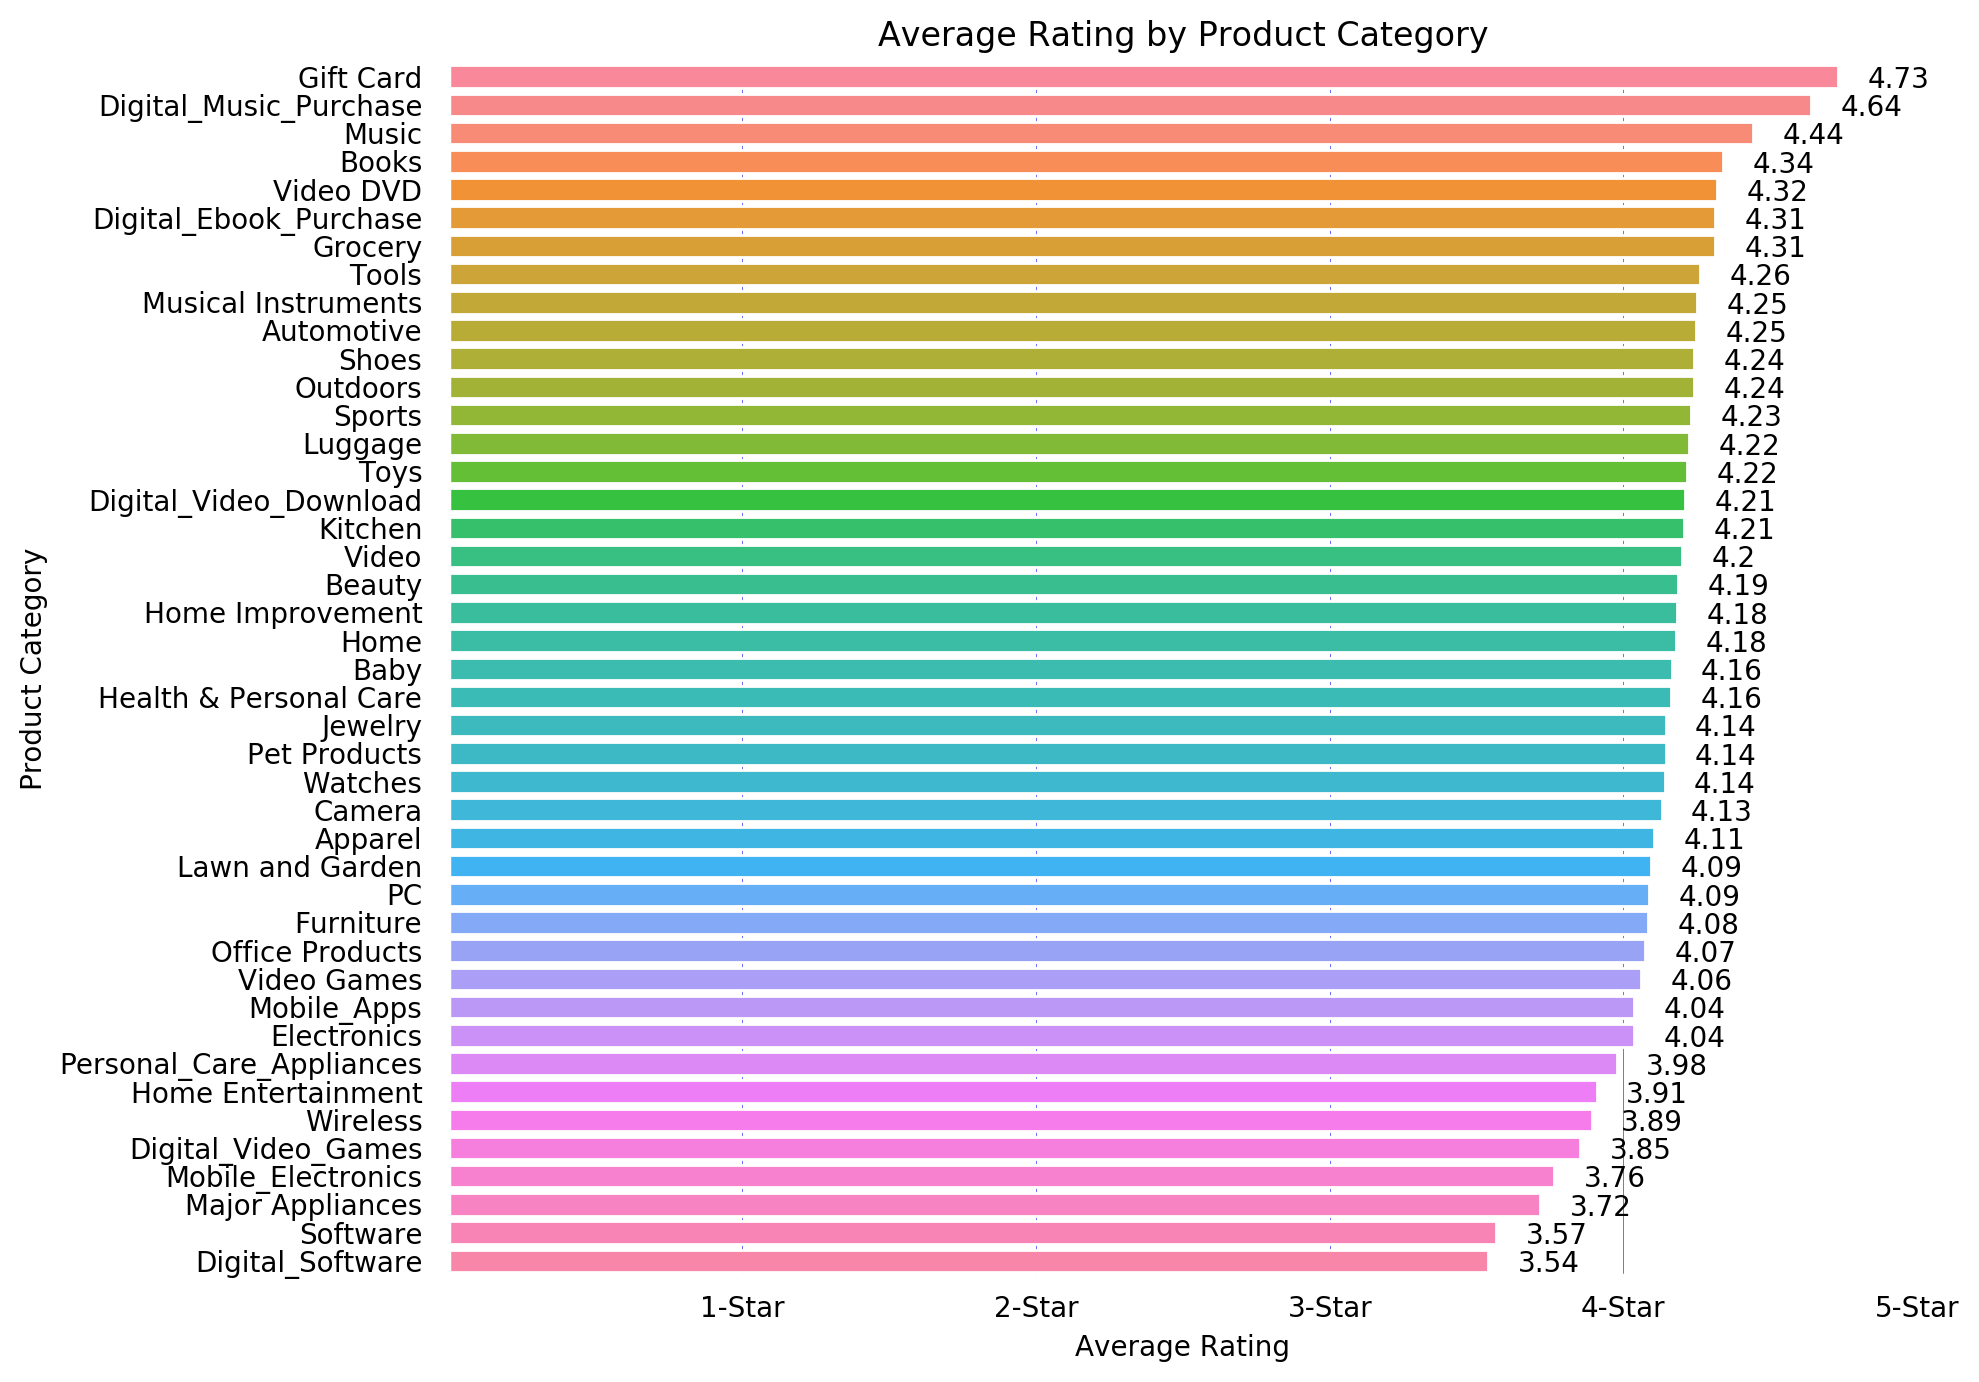

In [19]:
# Ploting a result in a horizontal bar chart using Seaborn and Matplotlib to provide high-level overview of which product categories are more popular than others, on average. As we can see from the chart Gift Cards are the highest rated product category with an average star ratingn of 4.73.
barplot = sns.barplot(y="product_category", x="avg_star_rating", data=df, saturation=1)

sns.set(
    rc={
        "font.style": "normal",
        "axes.facecolor": "white",
        "grid.color": "blue",
        "grid.linestyle": "-",
        "figure.facecolor": "white",
        "figure.titlesize": 10,
        "text.color": "black",
        "xtick.color": "black",
        "ytick.color": "black",
        "axes.labelcolor": "black",
        "axes.grid": True,
        "axes.labelsize": 10,
        "xtick.labelsize": 10,
        "font.size": 10,
        "ytick.labelsize": 10,
        "grid.linewidth": .2,
        "xtick.major.pad": 1.200000000000001,
        "figure.figsize": (15.0, 7.0)
    }
)

plt.title("Average Rating by Product Category")
plt.xticks([1, 2, 3, 4, 5], ["1-Star", "2-Star", "3-Star", "4-Star", "5-Star"])

plot_highest_rated_categories(barplot, 0.1)

plt.xlabel("Average Rating")
plt.ylabel("Product Category")

plt.tight_layout()

# Show graphic
plt.show(barplot)

In [25]:
#In order to get which product categories have the most reviews we will query AWS Athena

statement = """
SELECT product_category, COUNT(star_rating) AS count_star_rating 
FROM {}.{}
GROUP BY product_category 
ORDER BY count_star_rating DESC
""".format(
    database_name, table_name
)

print(statement)


SELECT product_category, COUNT(star_rating) AS count_star_rating 
FROM amazon_reviews_capstone.amazon_reviews_parquet
GROUP BY product_category 
ORDER BY count_star_rating DESC



In [26]:
df = pd.read_sql(statement, conn)
df.head()

,product_category,count_star_rating
0,Books,20628187
1,Digital_Ebook_Purchase,19160693
2,Wireless,9030379
3,PC,6981862
4,Mobile_Apps,6726245


In [28]:
# Calculate max ratings
max_ratings = df["count_star_rating"].max()
print(max_ratings)

20628187


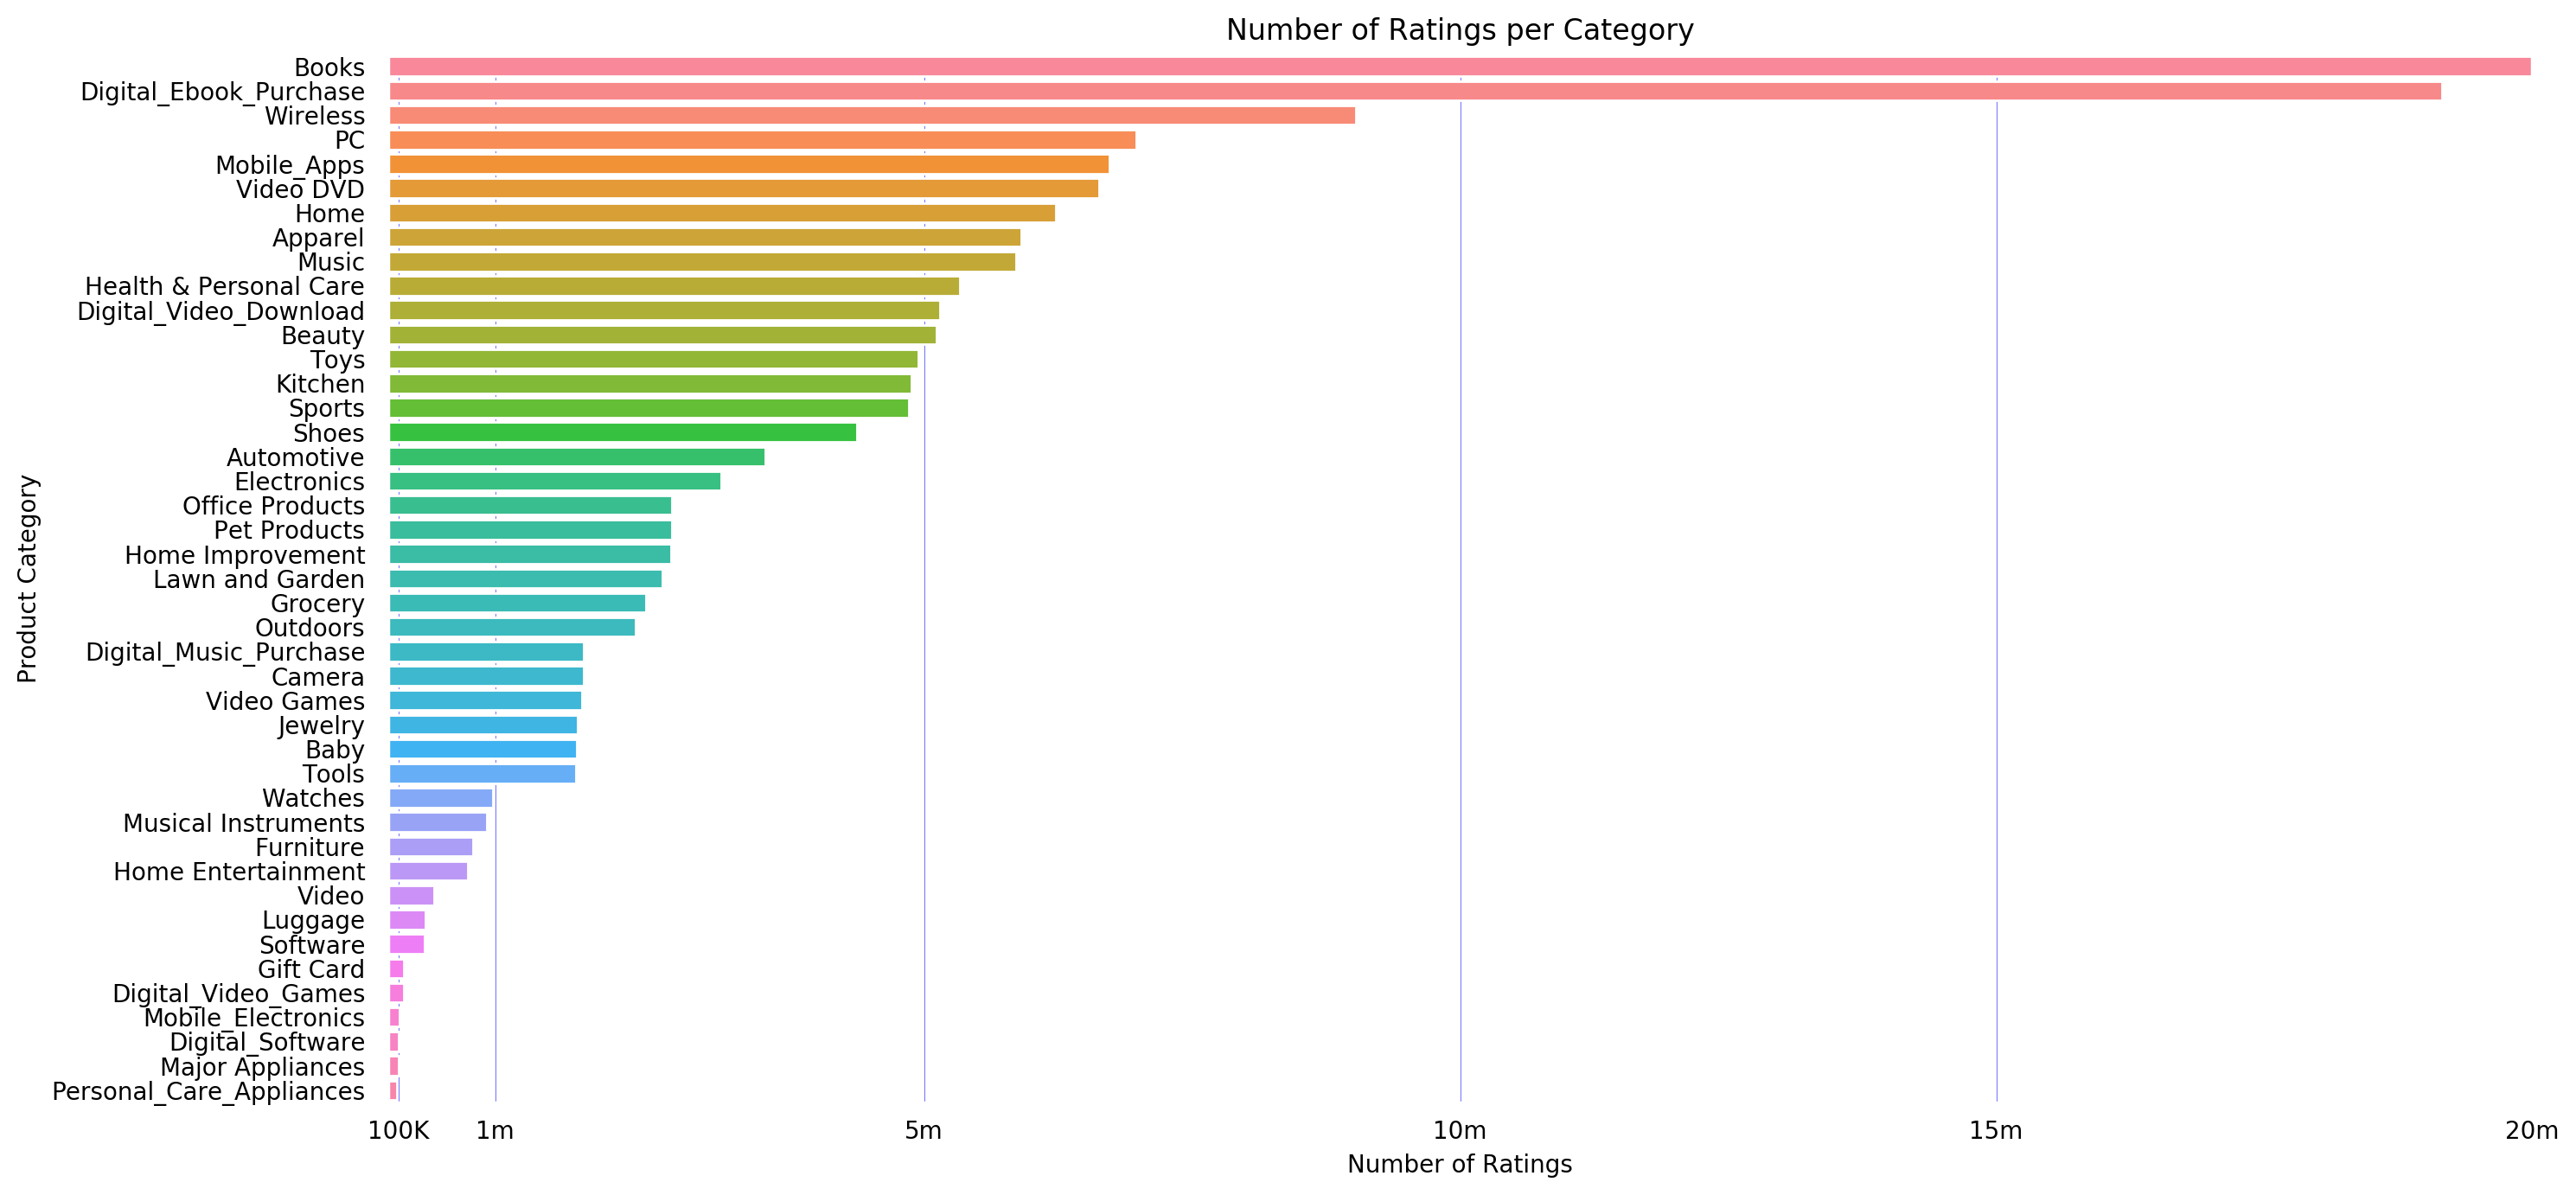

In [30]:
# Plotting the restul of the SQL query above in a horizontal bar chart again using Seaborn and Matplotlib where we can see that books category has the highest number of reviews
barplot = sns.barplot(y="product_category", x="count_star_rating", data=df, saturation=1)

plt.title("Number of Ratings per Category")

# Set x-axis ticks to match scale
if max_ratings > 200000:
    plt.xticks([100000, 1000000, 5000000, 10000000, 15000000, 20000000], ["100K", "1m", "5m", "10m", "15m", "20m"])
    plt.xlim(0, 20000000)
elif max_ratings <= 200000:
    plt.xticks([50000, 100000, 150000, 200000], ["50K", "100K", "150K", "200K"])
    plt.xlim(0, 200000)

plt.xlabel("Number of Ratings")
plt.ylabel("Product Category")

plt.tight_layout()
plt.show(barplot)

In [31]:
#  In order to get when did each category become available in the dataset or amazon catologue based on the date of the first review we will query AWS Athena
statement = """
SELECT product_category, MIN(review_date) AS first_review_date
FROM {}.{}
GROUP BY product_category
ORDER BY first_review_date 
""".format(
    database_name, table_name
)

df = pd.read_sql(statement, conn)
df.head()

,product_category,first_review_date
0,Books,1995-06-24
1,Video,1995-11-11
2,Music,1995-11-11
3,Video DVD,1996-07-08
4,Toys,1997-01-05


In [32]:
import datetime as datetime

dates = pd.to_datetime(df["first_review_date"])

In [33]:
def change_df(df):
    df["year"] = pd.to_datetime(df["first_review_date"], format="%Y-%m-%d").dt.year
    return df


def get_x_y(df):
    series = df["year"].value_counts().sort_index()
    return series.index, series.values

new_df =change_df(df)
print(new_df)

X, Y = get_x_y(new_df)

            product_category first_review_date  year
0                      Books        1995-06-24  1995
1                      Video        1995-11-11  1995
2                      Music        1995-11-11  1995
3                  Video DVD        1996-07-08  1996
4                       Toys        1997-01-05  1997
5                     Sports        1997-10-09  1997
6                Video Games        1997-11-06  1997
7                       Home        1998-05-29  1998
8            Office Products        1998-07-15  1998
9               Pet Products        1998-08-23  1998
10                  Software        1998-09-21  1998
11        Home Entertainment        1998-10-15  1998
12                    Camera        1998-11-20  1998
13                  Wireless        1998-12-04  1998
14    Health & Personal Care        1999-02-06  1999
15                  Outdoors        1999-03-24  1999
16               Electronics        1999-06-09  1999
17                        PC        1999-07-01

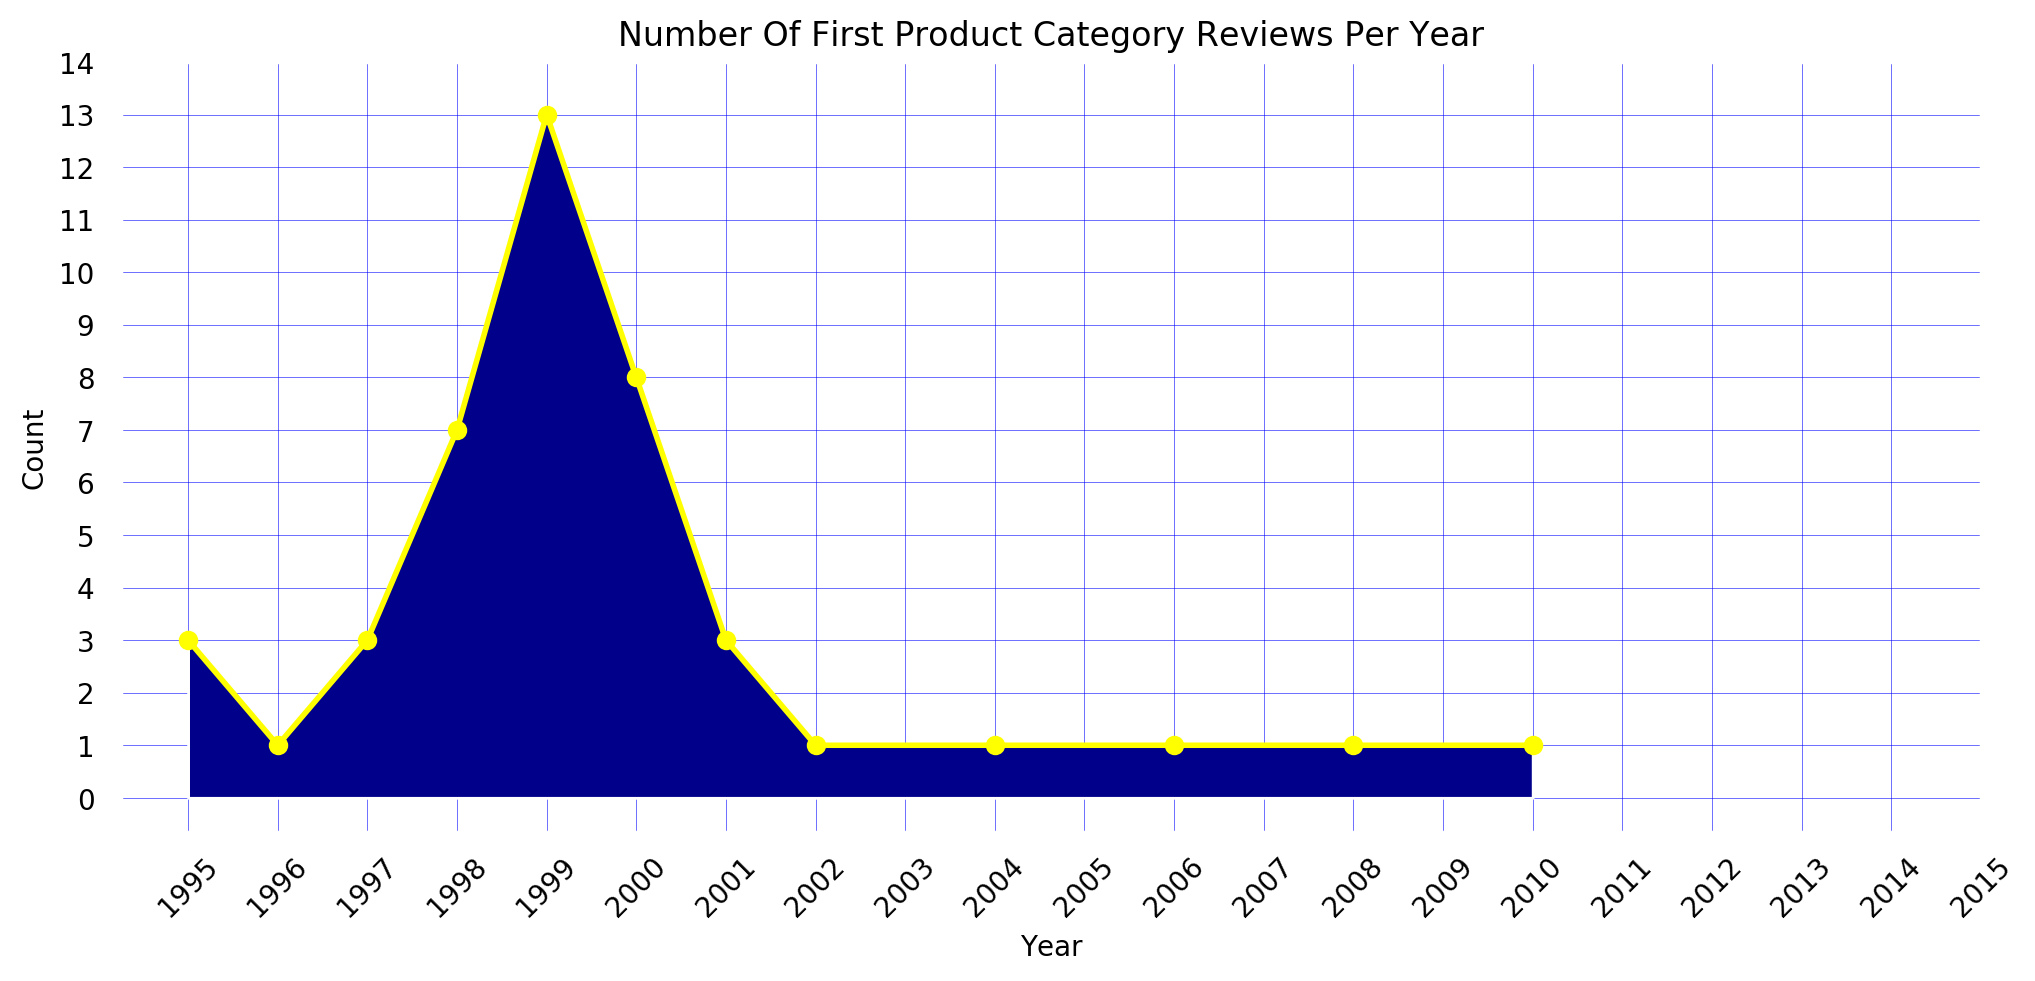

In [37]:
# Visualizing the number of first reviews per category per year 
fig = plt.figure(figsize=(12, 5))
ax = plt.gca()

ax.set_title("Number Of First Product Category Reviews Per Year")
ax.set_xlabel("Year")
ax.set_ylabel("Count")

ax.plot(X, Y, color="yellow", linewidth=2, marker="o")
ax.fill_between(X, [0] * len(X), Y, facecolor="darkblue")

ax.locator_params(integer=True)

ax.set_xticks(range(1995, 2016, 1))
ax.set_yticks(range(0, max(Y) + 2, 1))

plt.xticks(rotation=45)

plt.show()

In [38]:
#In order to get what is the breakdown of star ratings per produc category we will query AWS Athena
statement = """
SELECT product_category,
         star_rating,
         COUNT(*) AS count_reviews
FROM {}.{}
GROUP BY  product_category, star_rating
ORDER BY  product_category ASC, star_rating DESC, count_reviews
""".format(
    database_name, table_name
)

print(statement)


SELECT product_category,
         star_rating,
         COUNT(*) AS count_reviews
FROM amazon_reviews_capstone.amazon_reviews_parquet
GROUP BY  product_category, star_rating
ORDER BY  product_category ASC, star_rating DESC, count_reviews



In [39]:
df = pd.read_sql(statement, conn)
df


,product_category,star_rating,count_reviews
0,Apparel,5,3320649
1,Apparel,4,1147254
2,Apparel,3,623482
3,Apparel,2,369608
4,Apparel,1,445464
...,...,...,...
210,Wireless,5,4841384
211,Wireless,4,1506137
212,Wireless,3,817370
213,Wireless,2,599874


In [41]:
gc = df.groupby("product_category")
gs = df.groupby("star_rating")

df_sum = df.groupby(["star_rating"]).sum()

total = df_sum["count_reviews"].sum()
print(total)

159600938


In [42]:
dist= {}
count_review = []
i = 0

for category, ratings in gc:
    count_review = []
    for star in ratings["star_rating"]:
        count_review.append(ratings.at[i, "count_reviews"])
        i = i + 1
    dist[category] = count_review

# Check if disthas been created succesfully
print(dist)

{'Apparel': [3320649, 1147254, 623482, 369608, 445464], 'Automotive': [2301287, 526792, 239931, 147786, 299899], 'Baby': [1077529, 288766, 150581, 101346, 144944], 'Beauty': [3254945, 741443, 398405, 264029, 456898], 'Books': [13597324, 3529320, 1536197, 857735, 1107611], 'Camera': [1077981, 340997, 143183, 91828, 171393], 'Digital_Ebook_Purchase': [11599133, 4308090, 1699654, 748821, 804995], 'Digital_Music_Purchase': [1448408, 227882, 69064, 28080, 52611], 'Digital_Software': [46410, 16693, 8308, 6890, 23783], 'Digital_Video_Download': [3108347, 979887, 446704, 250029, 361739], 'Digital_Video_Games': [80677, 20406, 11629, 7749, 24970], 'Electronics': [1791404, 539998, 239906, 180136, 359735], 'Furniture': [447721, 153667, 73564, 43849, 73320], 'Gift Card': [129709, 9859, 3156, 1569, 4793], 'Grocery': [1662276, 293389, 161497, 105265, 180049], 'Health & Personal Care': [3358962, 781999, 400558, 278058, 513189], 'Home': [3896160, 959948, 500722, 324242, 545188], 'Home Entertainment': [

In [43]:
print(dist.keys())

dict_keys(['Apparel', 'Automotive', 'Baby', 'Beauty', 'Books', 'Camera', 'Digital_Ebook_Purchase', 'Digital_Music_Purchase', 'Digital_Software', 'Digital_Video_Download', 'Digital_Video_Games', 'Electronics', 'Furniture', 'Gift Card', 'Grocery', 'Health & Personal Care', 'Home', 'Home Entertainment', 'Home Improvement', 'Jewelry', 'Kitchen', 'Lawn and Garden', 'Luggage', 'Major Appliances', 'Mobile_Apps', 'Mobile_Electronics', 'Music', 'Musical Instruments', 'Office Products', 'Outdoors', 'PC', 'Personal_Care_Appliances', 'Pet Products', 'Shoes', 'Software', 'Sports', 'Tools', 'Toys', 'Video', 'Video DVD', 'Video Games', 'Watches', 'Wireless'])


In [44]:
print(dist.items())

dict_items([('Apparel', [3320649, 1147254, 623482, 369608, 445464]), ('Automotive', [2301287, 526792, 239931, 147786, 299899]), ('Baby', [1077529, 288766, 150581, 101346, 144944]), ('Beauty', [3254945, 741443, 398405, 264029, 456898]), ('Books', [13597324, 3529320, 1536197, 857735, 1107611]), ('Camera', [1077981, 340997, 143183, 91828, 171393]), ('Digital_Ebook_Purchase', [11599133, 4308090, 1699654, 748821, 804995]), ('Digital_Music_Purchase', [1448408, 227882, 69064, 28080, 52611]), ('Digital_Software', [46410, 16693, 8308, 6890, 23783]), ('Digital_Video_Download', [3108347, 979887, 446704, 250029, 361739]), ('Digital_Video_Games', [80677, 20406, 11629, 7749, 24970]), ('Electronics', [1791404, 539998, 239906, 180136, 359735]), ('Furniture', [447721, 153667, 73564, 43849, 73320]), ('Gift Card', [129709, 9859, 3156, 1569, 4793]), ('Grocery', [1662276, 293389, 161497, 105265, 180049]), ('Health & Personal Care', [3358962, 781999, 400558, 278058, 513189]), ('Home', [3896160, 959948, 5007

In [58]:
dist_sort= {}

avg_sr.iloc[:, 0]
for index, value in avg_sr.iloc[:, 0].items():
    dist_sort[value] = dist[value]

In [59]:
df_dist_sort_pct = pd.DataFrame(dist_sort).transpose().apply(
    lambda num_ratings: num_ratings/sum(num_ratings)*100, axis=1
)
df_dist_sort_pct.columns=['5', '4', '3', '2', '1']
df_dist_sort_pct

,5,4,3,2,1
Gift Card,87.002804,6.612962,2.116899,1.052413,3.214923
Digital_Music_Purchase,79.319403,12.479539,3.782163,1.537750,2.881145
Music,69.588628,16.481381,6.520428,3.262159,4.147404
Books,65.916234,17.109211,7.447077,4.158073,5.369405
Video DVD,66.374593,15.804328,7.418863,4.054574,6.347642
Digital_Ebook_Purchase,60.536083,22.483999,8.870525,3.908110,4.201283
Grocery,69.190119,12.211943,6.722107,4.381521,7.494310
Tools,63.955084,17.205723,7.242152,4.292266,7.304774
Musical Instruments,63.308519,17.543944,7.408645,4.440310,7.298582
Automotive,65.457527,14.984007,6.824568,4.203607,8.530291


<Figure size 1000x1000 with 0 Axes>

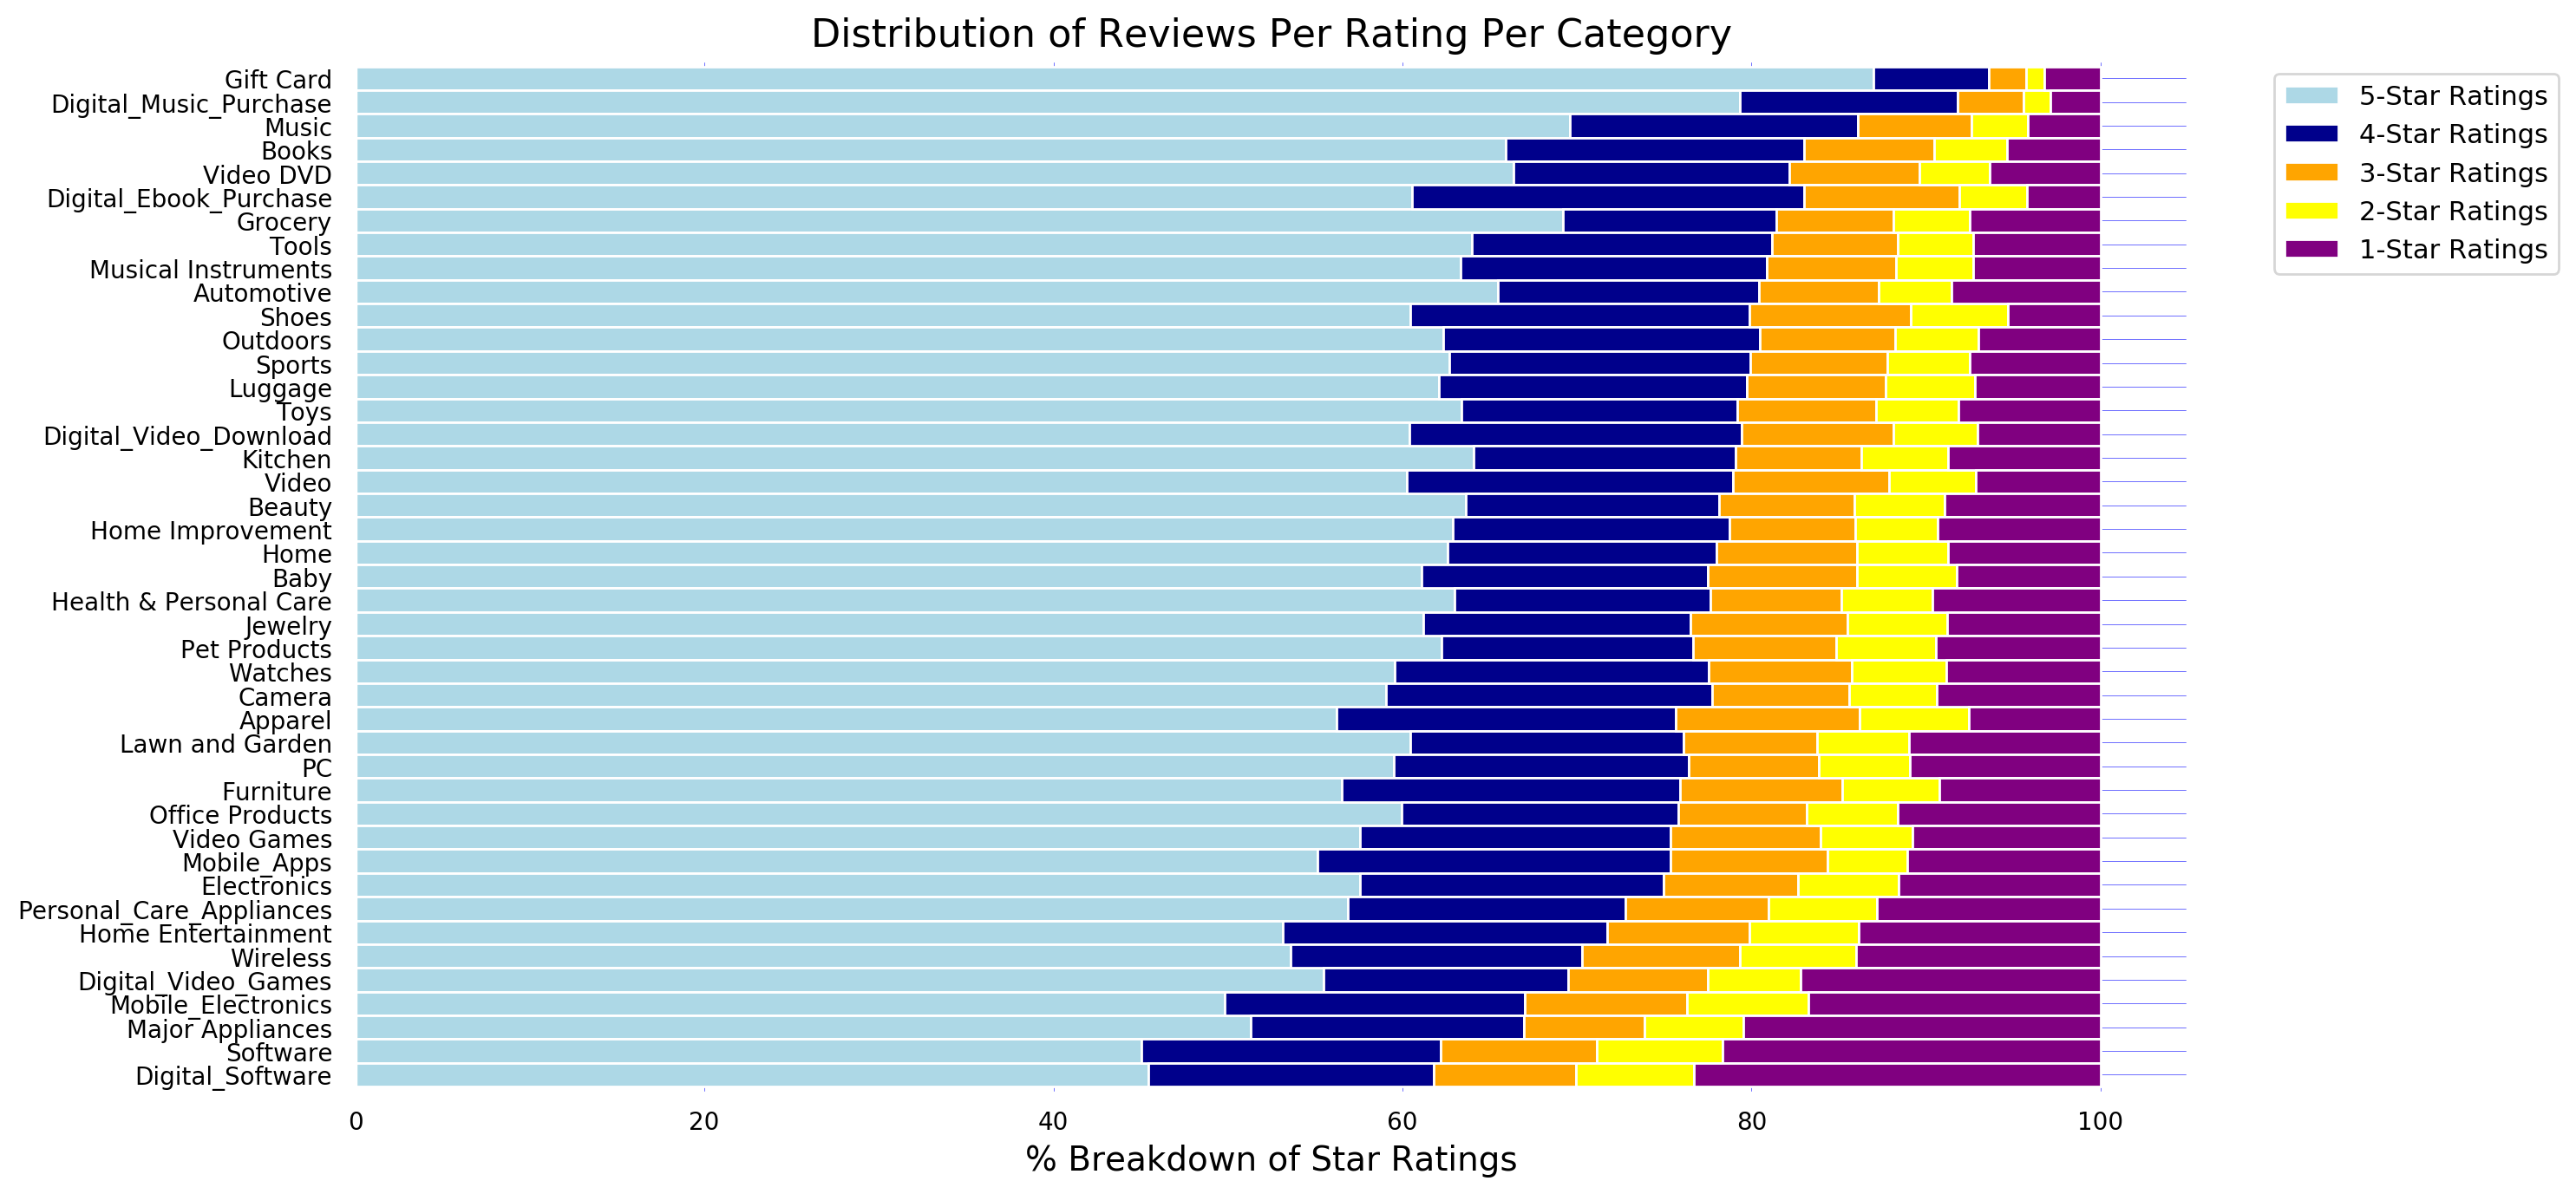

In [62]:
categories = df_dist_sort_pct.index

# From the plot below we can see that aproximately 60% of all reviews have 5 star rating
if len(categories) > 10:
    plt.figure(figsize=(10,10))
else: 
    plt.figure(figsize=(10,5))

df_dist_sort_pct.plot(kind="barh", 
                                stacked=True, 
                                edgecolor='white',
                                width=1.0,
                                color=['lightblue', 
                                       'darkblue', 
                                       'orange', 
                                       'yellow', 
                                       'purple'])

plt.title("Distribution of Reviews Per Rating Per Category", 
          fontsize='16')

plt.legend(bbox_to_anchor=(1.04,1), 
           loc="upper left",
           labels=['5-Star Ratings', 
                   '4-Star Ratings', 
                   '3-Star Ratings', 
                   '2-Star Ratings', 
                   '1-Star Ratings'])

plt.xlabel("% Breakdown of Star Ratings", fontsize='14')
plt.gca().invert_yaxis()
plt.tight_layout()

plt.show()

In [63]:
# How many reviews per star rating for all product categories
statement = """
SELECT star_rating,
         COUNT(*) AS count_reviews
FROM amazon_reviews_capstone.amazon_reviews_parquet
GROUP BY  star_rating
ORDER BY  star_rating DESC, count_reviews 
""".format(
    database_name, table_name
)

print(statement)



SELECT star_rating,
         COUNT(*) AS count_reviews
FROM amazon_reviews_capstone.amazon_reviews_parquet
GROUP BY  star_rating
ORDER BY  star_rating DESC, count_reviews 



In [64]:
df = pd.read_sql(statement, conn)
df

,star_rating,count_reviews
0,5,98788976
1,4,27781630
2,3,12796405
3,2,7643093
4,1,12590834


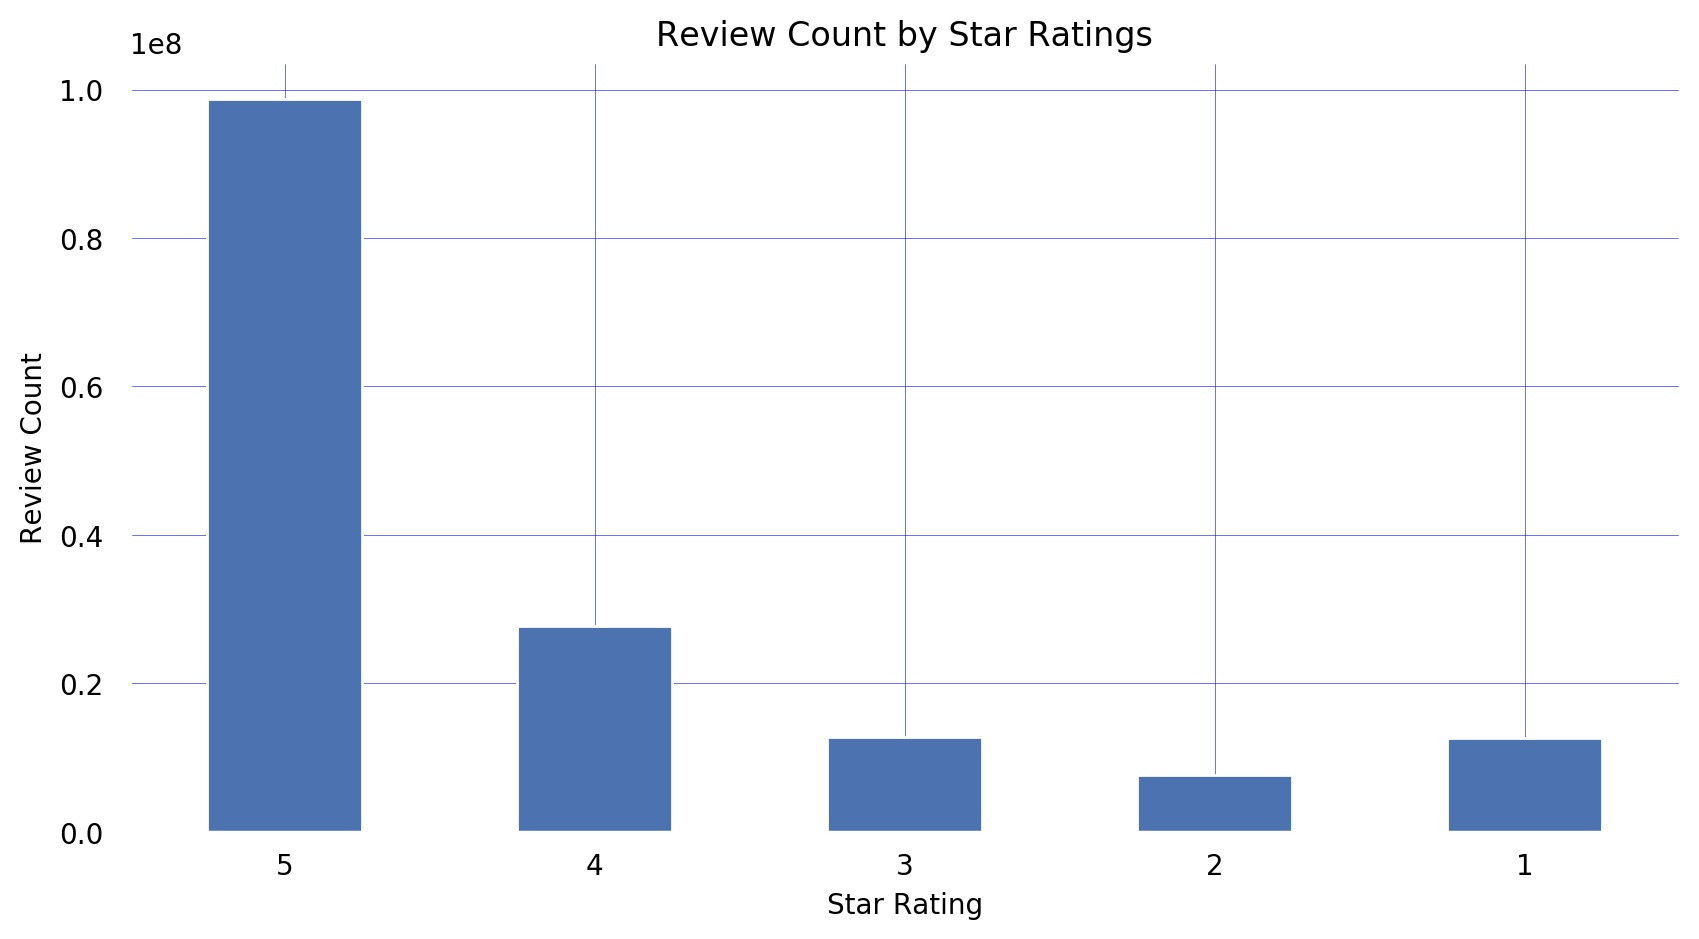

In [66]:
avg_sr = df.plot.bar(
    x="star_rating", y="count_reviews", rot="0", figsize=(10, 5), title="Review Count by Star Ratings", legend=False
)

plt.xlabel("Star Rating")
plt.ylabel("Review Count")

plt.show(avg_sr)

In [67]:
# How did star rating change over time 
statement = """
SELECT year, ROUND(AVG(star_rating),4) AS avg_rating
FROM {}.{}
GROUP BY year
ORDER BY year
""".format(
    database_name, table_name
)

print(statement)


SELECT year, ROUND(AVG(star_rating),4) AS avg_rating
FROM amazon_reviews_capstone.amazon_reviews_parquet
GROUP BY year
ORDER BY year



In [68]:
df = pd.read_sql(statement, conn)
df

,year,avg_rating
0,1995,4.6238
1,1996,4.6060
2,1997,4.4319
3,1998,4.3635
4,1999,4.2881
5,2000,4.2609
6,2001,4.2024
7,2002,4.1659
8,2003,4.1218
9,2004,4.0637


In [69]:
df["year"] = pd.to_datetime(df["year"], format="%Y").dt.year

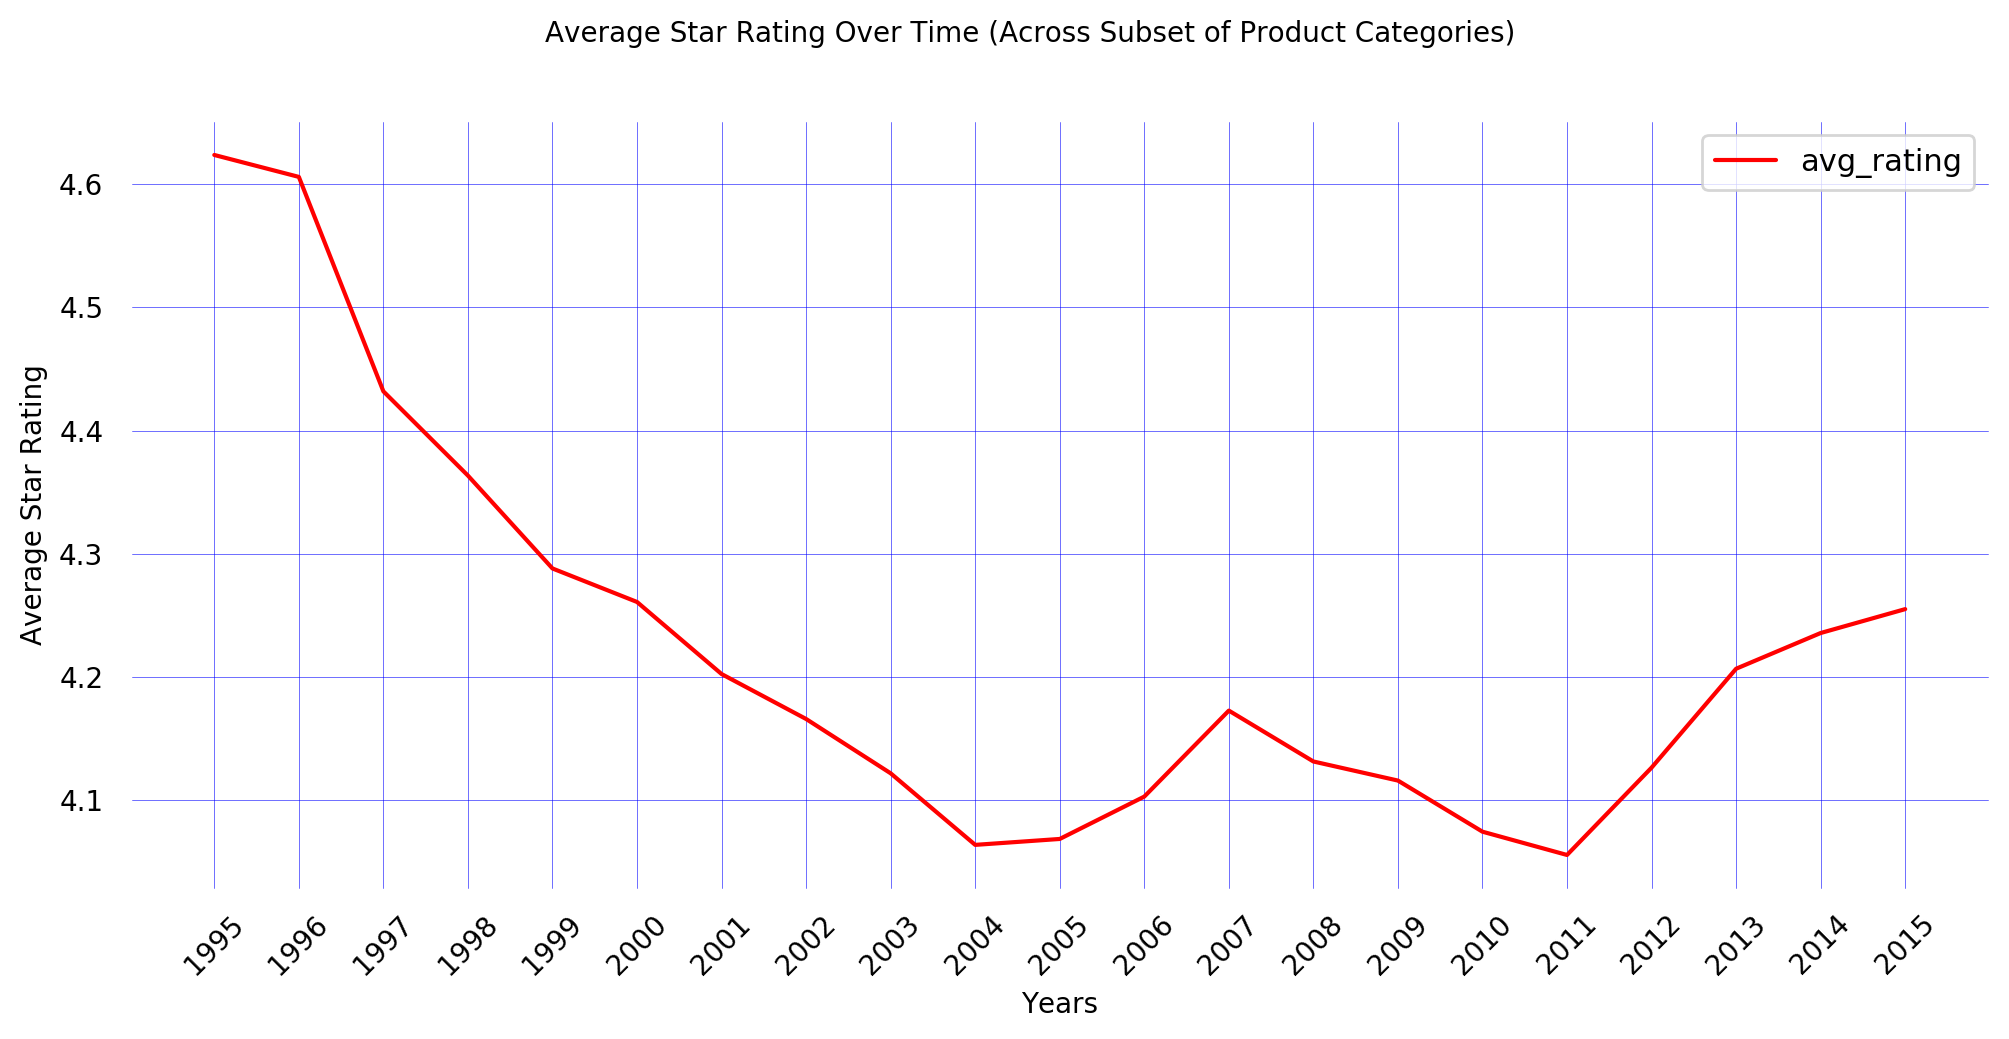

In [70]:
fig = plt.gcf()
fig.set_size_inches(12, 5)

fig.suptitle("Average Star Rating Over Time (Across Subset of Product Categories)")

ax = plt.gca()
# ax = plt.gca().set_xticks(df['year'])
ax.locator_params(integer=True)
ax.set_xticks(df["year"].unique())

df.plot(kind="line", x="year", y="avg_rating", color="red", ax=ax)

# plt.xticks(range(1995, 2016, 1))
# plt.yticks(range(0,6,1))
plt.xlabel("Years")
plt.ylabel("Average Star Rating")
plt.xticks(rotation=45)

# fig.savefig('average-rating.png', dpi=300)
plt.show()

In [71]:
# Average star rating over time per produc category
statement = """
SELECT product_category, year, ROUND(AVG(star_rating), 4) AS avg_rating_category
FROM {}.{}
GROUP BY product_category, year
ORDER BY year 
""".format(
    database_name, table_name
)

print(statement)


SELECT product_category, year, ROUND(AVG(star_rating), 4) AS avg_rating_category
FROM amazon_reviews_capstone.amazon_reviews_parquet
GROUP BY product_category, year
ORDER BY year 



In [72]:
df = pd.read_sql(statement, conn)
df

,product_category,year,avg_rating_category
0,Video,1995,5.0000
1,Books,1995,4.6146
2,Music,1995,5.0000
3,Books,1996,4.6084
4,Video DVD,1996,4.0000
...,...,...,...
703,Shoes,2015,4.2560
704,Camera,2015,4.1916
705,Digital_Ebook_Purchase,2015,4.3502
706,Video Games,2015,4.2356


In [73]:
def show_plot(df):
    df_categories = df["product_category"].unique()
    for category in df_categories:
        # print(category)
        df_plot = df.loc[df["product_category"] == category]
        df_plot.plot(
            kind="line",
            x="year",
            y="avg_rating_category",
            c=np.random.rand(
                3,
            ),
            ax=ax,
            label=category,
        )

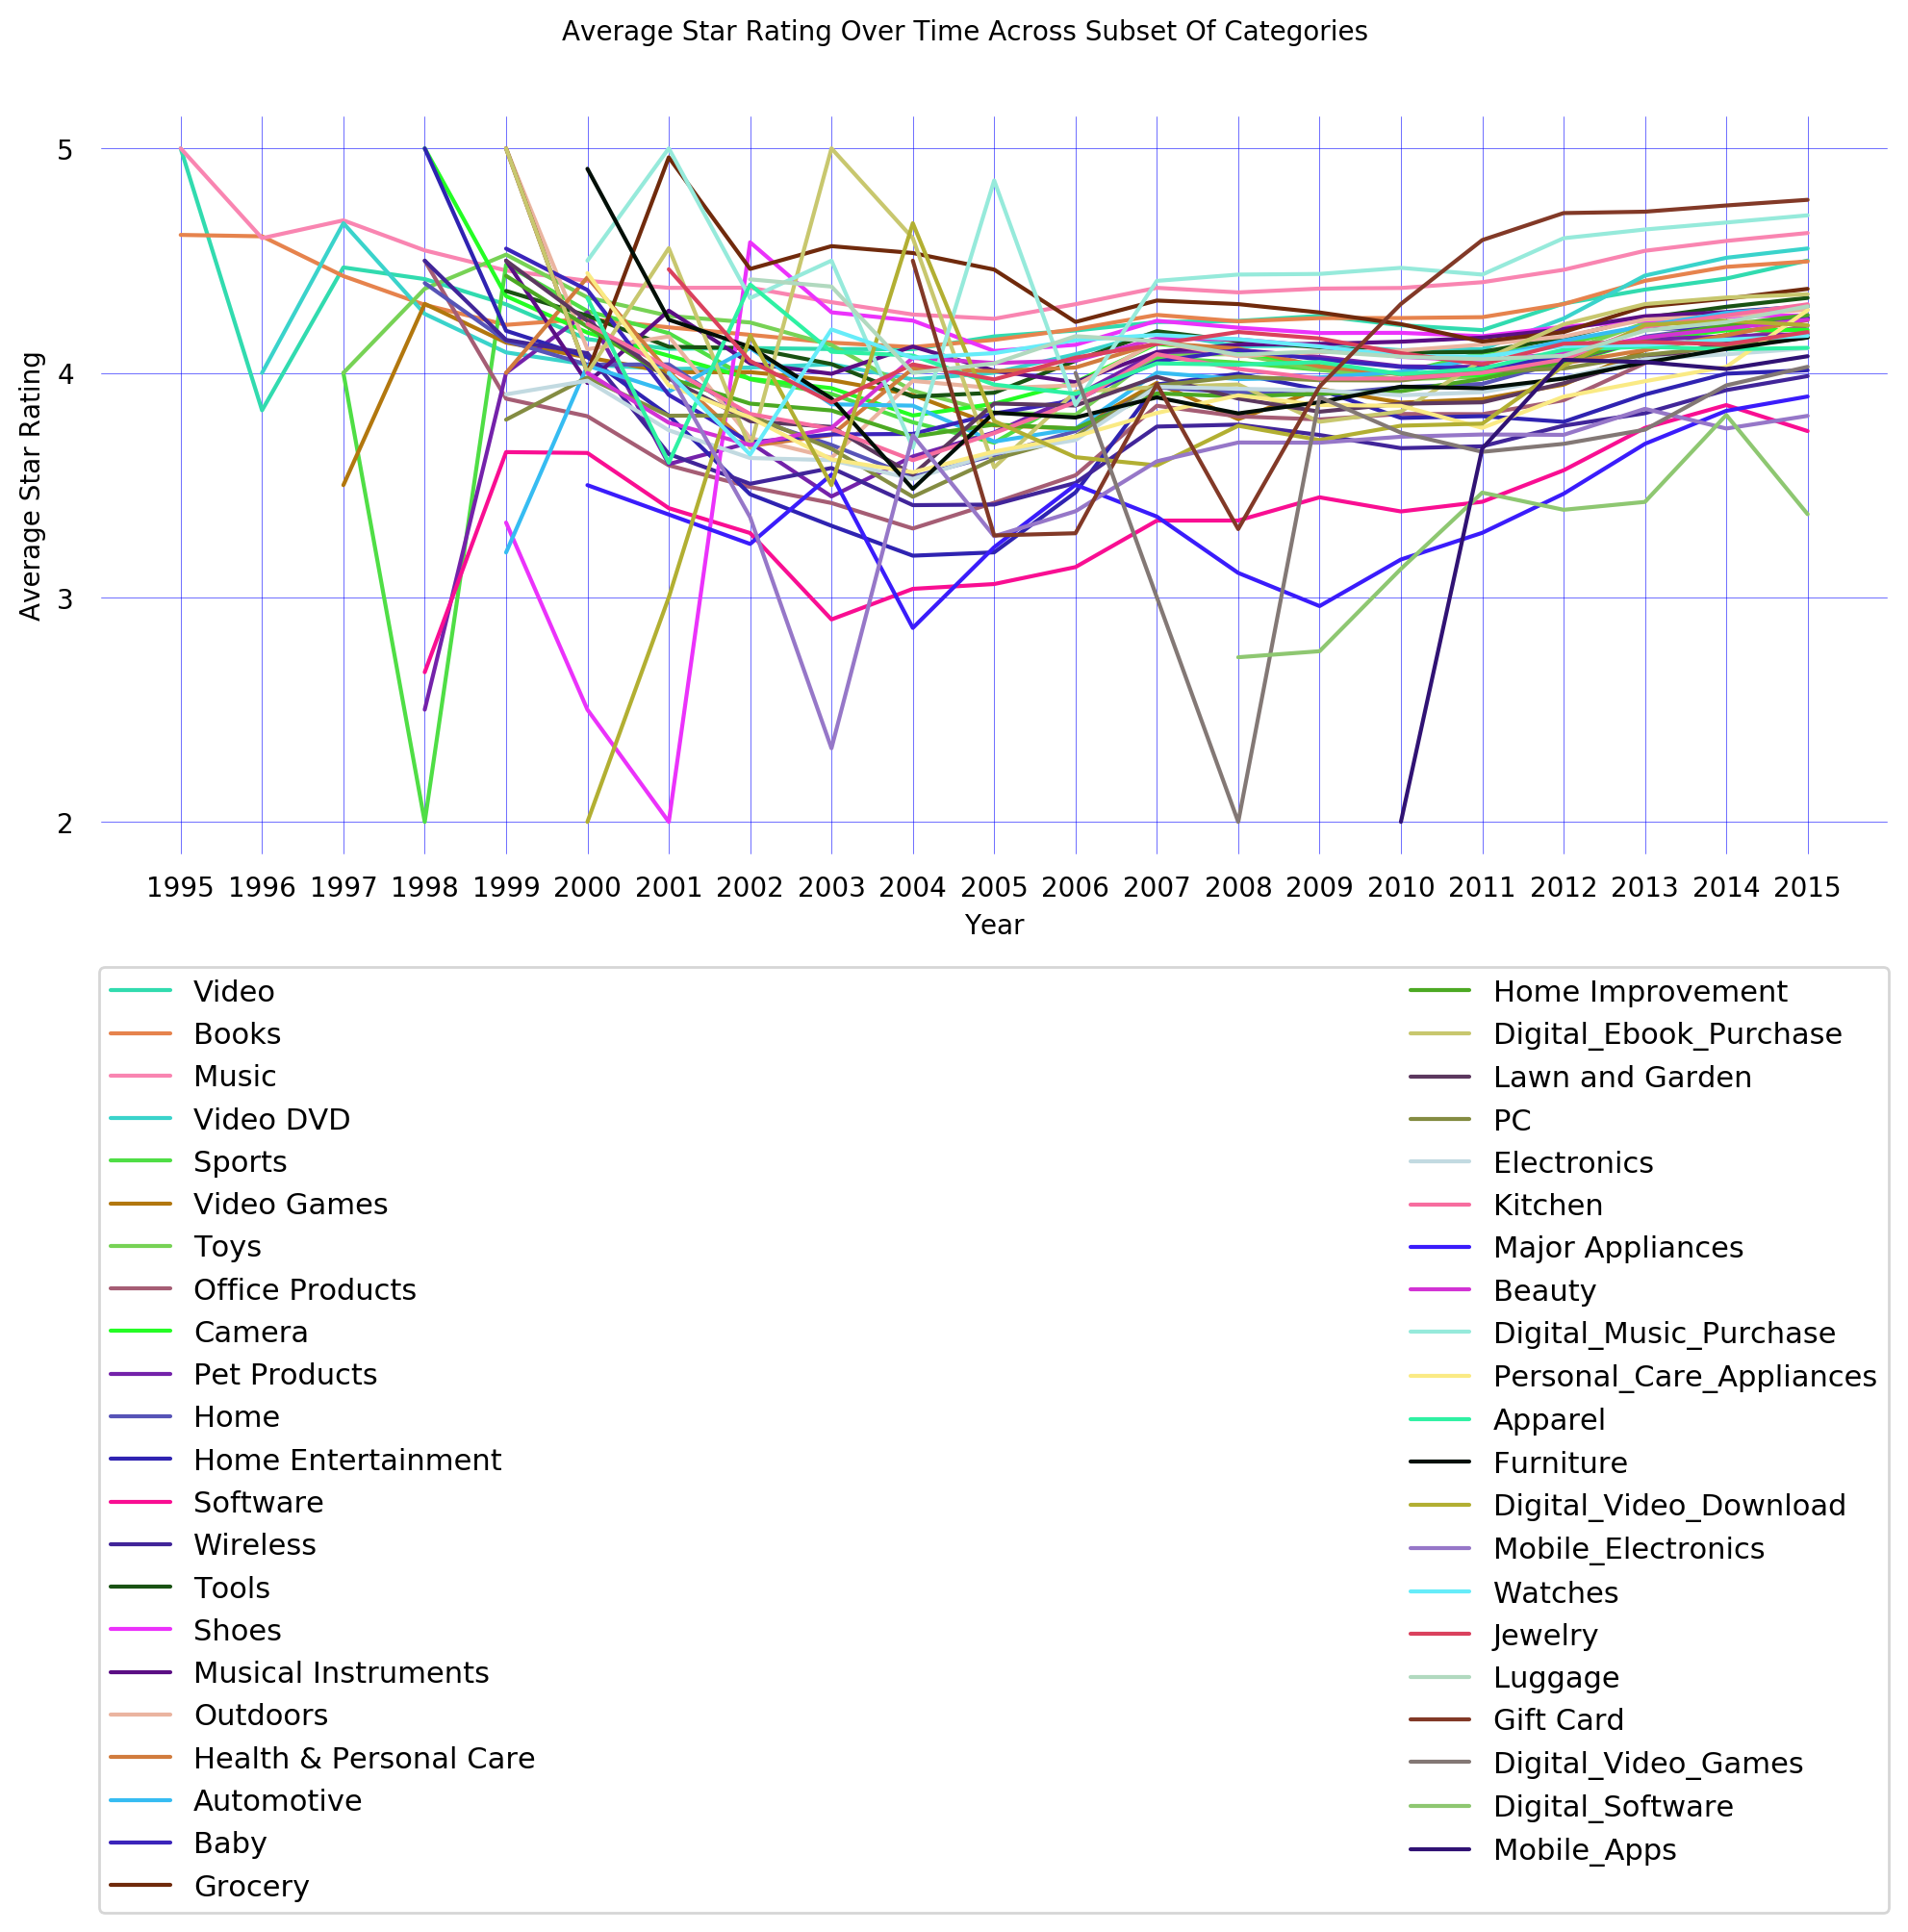

In [74]:
fig = plt.gcf()
fig.set_size_inches(12, 5)

fig.suptitle("Average Star Rating Over Time Across Subset Of Categories")

ax = plt.gca()

ax.locator_params(integer=True)
ax.set_xticks(df["year"].unique())

show_plot(df)

plt.xlabel("Year")
plt.ylabel("Average Star Rating")
plt.legend(bbox_to_anchor=(0, -0.15, 1, 0), loc=2, ncol=2, mode="expand", borderaxespad=0)

plt.show()

In [75]:
# Helpfulness of star ratings
statement = """
SELECT star_rating,
         AVG(helpful_votes) AS avg_helpful_votes
FROM {}.{}
GROUP BY  star_rating
ORDER BY  star_rating ASC
""".format(
    database_name, table_name
)

print(statement)


SELECT star_rating,
         AVG(helpful_votes) AS avg_helpful_votes
FROM amazon_reviews_capstone.amazon_reviews_parquet
GROUP BY  star_rating
ORDER BY  star_rating ASC



In [76]:
df = pd.read_sql(statement, conn)
df

,star_rating,avg_helpful_votes
0,1,3.794532
1,2,2.546928
2,3,2.052965
3,4,1.666420
4,5,1.676229


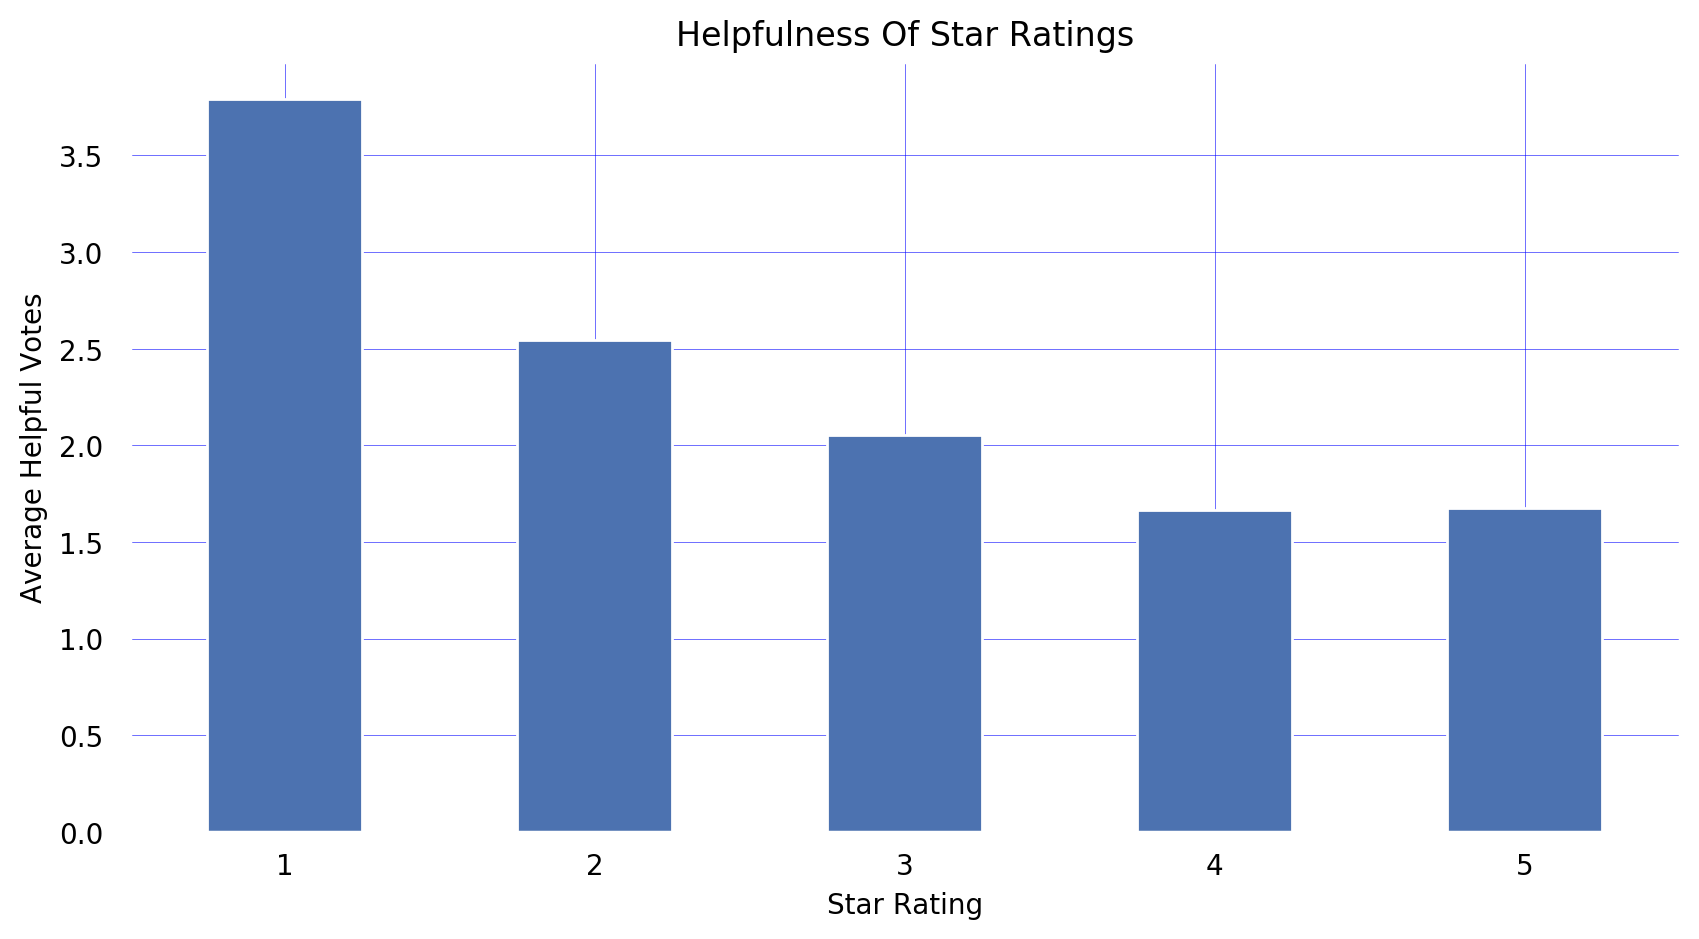

In [77]:
chart = df.plot.bar(
    x="star_rating", y="avg_helpful_votes", rot="0", figsize=(10, 5), title="Helpfulness Of Star Ratings", legend=False
)

plt.xlabel("Star Rating")
plt.ylabel("Average Helpful Votes")

plt.show(chart)

In [78]:
# Which product has most helpful review
statement = """
SELECT product_title,
         helpful_votes,
         star_rating,
         LENGTH(review_body) AS review_body_length,
         SUBSTR(review_body, 1, 100) AS review_body_substr
FROM {}.{}
ORDER BY helpful_votes DESC LIMIT 10 
""".format(
    database_name, table_name
)

print(statement)


SELECT product_title,
         helpful_votes,
         star_rating,
         LENGTH(review_body) AS review_body_length,
         SUBSTR(review_body, 1, 100) AS review_body_substr
FROM amazon_reviews_capstone.amazon_reviews_parquet
ORDER BY helpful_votes DESC LIMIT 10 



In [79]:
df = pd.read_sql(statement, conn)
df

,product_title,helpful_votes,star_rating,review_body_length,review_body_substr
0,Kindle: Amazon's Original Wireless Reading Dev...,47524,5,12906,"This is less a \\""pros and cons\\"" review than..."
1,"BIC Cristal For Her Ball Pen, 1.0mm, Black, 16...",41393,5,863,Someone has answered my gentle prayers and FIN...
2,The Mountain Kids 100% Cotton Three Wolf Moon ...,41278,5,1566,This item has wolves on it which makes it intr...
3,"Kindle Keyboard 3G, Free 3G + Wi-Fi, 6"" E Ink ...",31924,5,23069,UPDATE NOVEMBER 2011:<br /><br />My review is ...
4,"Kindle Fire HD 7"", Dolby Audio, Dual-Band Wi-Fi",31417,4,13594,I've been an iPad user since the original came...
5,Kindle Fire (Previous Generation - 1st),28611,4,29778,UPDATE November 2012 - With the [[ASIN:B007T36...
6,Fifty Shades of Grey: Book One of the Fifty Sh...,27550,2,2849,I really don't like writing bad reviews. I adm...
7,Fifty Shades of Grey: Book One of the Fifty Sh...,27550,2,2849,I really don't like writing bad reviews. I adm...
8,Wheelmate Laptop Steering Wheel Desk,26132,5,572,My husband Brad always warns me not to try and...
9,"Kindle Wireless Reading Device (6"" Display, U....",24714,1,10222,I was DELIGHTED to upgrade my Kindle 1 to K2.....


In [80]:
# What is the Ratio of Positive (5, 4) to Negative (3, 2 ,1) Reviews
statement = """
SELECT customer_id, product_category, product_title, 
ROUND(AVG(star_rating),4) AS avg_star_rating, COUNT(*) AS review_count 
FROM amazon_reviews_capstone.amazon_reviews_parquet 
GROUP BY customer_id, product_category, product_title 
HAVING COUNT(*) > 1 
ORDER BY review_count DESC
LIMIT 5
""".format(
    database_name, table_name
)

print(statement)


SELECT customer_id, product_category, product_title, 
ROUND(AVG(star_rating),4) AS avg_star_rating, COUNT(*) AS review_count 
FROM amazon_reviews_capstone.amazon_reviews_parquet 
GROUP BY customer_id, product_category, product_title 
HAVING COUNT(*) > 1 
ORDER BY review_count DESC
LIMIT 5



In [81]:
df = pd.read_sql(statement, conn)
df

,customer_id,product_category,product_title,avg_star_rating,review_count
0,38118182,Video DVD,Pearl Harbor,4.2308,260
1,33132919,Video DVD,Shania Twain - Up (Live in Chicago),5.0000,220
2,52895956,Books,Frankenstein,3.0349,172
3,29088361,Music,In The Zone,4.9672,122
4,23974294,Video DVD,Shania Twain - Up (Live in Chicago),5.0000,114


In [12]:
statement = """
SELECT CARDINALITY(SPLIT(review_body, ' ')) as num_words
FROM amazon_reviews_capstone.amazon_reviews_parquet LIMIT 100000
"""
print(statement)


SELECT CARDINALITY(SPLIT(review_body, ' ')) as num_words
FROM amazon_reviews_capstone.amazon_reviews_parquet LIMIT 100000



In [13]:
df = pd.read_sql(statement, conn)

In [9]:
summary = df["num_words"].describe(percentiles=[0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00])
summary

count    100000.000000
mean         54.510140
std          98.573889
min           1.000000
10%           3.000000
20%           9.000000
30%          20.000000
40%          23.000000
50%          28.000000
60%          36.000000
70%          49.000000
80%          71.000000
90%         120.000000
100%       5555.000000
max        5555.000000
Name: num_words, dtype: float64